In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns              

%matplotlib inline

# **Task 1**

In [305]:
def global_alignment(X, Y, gap_score):

    #Mapping nucleotide characters to indices for the substitution matrix using a dict
    nt_map = {'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3}

    #First need to init a sigma matrix from which we can draw values for matches or mismatches, values hardcoded from pset instructions
    sigma = np.array([
        [ 1.85, -2.91, -2.91, -2.91 ],  # A row, index 0
        [ -2.91, 1.85, -2.91, -2.91 ],  # C row, index 1
        [ -2.91, -2.91, 1.85, -2.91 ],  # G row, index 2
        [ 0, 0, 0, 0 ]                  # T row, index 3
    ])

    #Initialization
    #Need to elongate for correct shape of matrix and also to init top left corner to (0) and for easier matrix indexing 
    #'*' serves as a dummy placeholder to make alignment easier with 1-based indexing
    X = '*' + X
    Y = '*' + Y

    L = len(X)
    M = len(Y)

    #Init the scoring matrix F with global alignment scores
    F = np.zeros((L,M))

    #Init the first column of the matrix F
    #Assigning gap penalties for any gaps in X (only 'T' gaps allowed), penalize with the gap_score; others are set to -inf to heavily penalize and thus not consider non-T gaps due to the nature of Moriarty's model

    for i in range(1,L):
        if X[i] in list('ACG'):
            F[i,0] = -np.inf #Non-T gaps are heavily penalized (invalid)
        else:
            F[i,0] = i * gap_score #Apply the gap penalty for 'T' gaps

    #Init the first row of the matrix F, same logic
    for j in range(1,M):
        if Y[j] in list('ACG'):
            F[0,j] = -np.inf #Non-T gaps are heavily penalized (invalid)
        else: 
            F[0,j] = j * gap_score #Apply the gap penalty for 'T' gaps

    #Recursion 
    #Iterate through pairwise to fill matrix
    for i in range(1,L):
        for j in range(1,M): 
            
            match = F[i-1,j-1] + sigma[ nt_map[X[i]], nt_map[Y[j]] ] #Get the score for match/mismatch by adding the score
            #from the sigma matrix for the current characters X[i] and Y[j] to the diagonally previous score 

            #Calculate the score for an insertion (gap in Y) if X[i] is 'T' (since gaps are only allowed for T)
            if X[i] == 'T': 
                insertion = F[i-1, j] + gap_score
            else:
                insertion = -np.inf #Non-T insertions are not allowed and so heavily penalized

            #Calculate the score for a deletion (gap in X) if Y[j] is 'T' (since gaps are only allowed for T)
            if Y[j] == 'T':
                deletion = F[i,j-1] + gap_score
            else:
                deletion = -np.inf #Non-T deletions are not allowed and so heavily penalized

            F[i,j] = max(match,deletion,insertion)

    #Termination 
    #Final alignment score is in the last cell of the matrix F, represents the optimal alignment score for aligning all characters of X and Y
    return F[L-1,M-1]

In [306]:
#Testing global_alignment 
seq1 = 'TCACCTACCGCGGTCGGCGCGTCTTCGGCCCG'
seq2 = 'ACACCACCGCGGGTGGCGCGCCCCCGGCTCCG'

print('The global alignment for the provided test sequences is: ', global_alignment(seq1, seq2, -5))

The global alignment for the provided test sequences is:  33.34000000000001


# **Task 2**

In [307]:
def sim_read(input_seq):
    
    rng = np.random.default_rng() #a random number generator for simulating random events, used for probabalistic calls
    sim_seq = '' #Empty string to add the sim_read to and store base seq
    
    #Loop through each base in the input sequence
    for base in input_seq: 
        #If the base is A/C/G, simulate reading with 90% accuracy
        if base in list('ACG'):
            if rng.random() < 0.9:
                sim_seq += base #90% chance of correct A/C/G incorporation 
            else: #10% chance of substitution with a different nucleotide (not itself)
                if base == 'A':
                    sim_seq += rng.choice(list('CGT')) 
                if base == 'C':
                    sim_seq += rng.choice(list('AGT'))
                if base == 'G':
                    sim_seq += rng.choice(list('ACT'))
        
        elif base == 'T':
            #3.125% chance of deleting the T (skip this base)
            if rng.random() < 0.03125:  
                continue #simulating a T deletion 
            else: #Otherwise, replace T with one of A/C/G/T (random uniform substitution) - 25% correct T
                sim_seq += rng.choice(list('ACGT'))
                
        #Randomly insert additional Ts at a rate of 3.125% (the while loop handles multiple insertions)
        while rng.random() < 0.03125:
            sim_seq += 'T'

    return sim_seq #Length may be same as, greater than or less than that of input_seq  

In [308]:
def generate_random_seq(length):
    rng = np.random.default_rng() #A random number generator - for choosing bases 
    sequence_list = rng.choice(list('ACGT'), size=length) #Get a list of bases of length L, each base has uniform p of being picked (25%) by rng.choice
    sequence = ''.join(sequence_list) #Join the list of nucleotides into a string to return
    return sequence

In [309]:
def generate_pairs_v1(num_trials):

    positive_control_pairs = [] #Init a list to store positive control sequence pairs
    negative_control_pairs = [] #Init a list to store negative control sequence pairs

    #For loop to generate len=num_trials positive and negative control pairs
    for i in range(num_trials):
        positive_input = generate_random_seq(32) #Generate a random 32nt input sequence
        positive_sim_pair = sim_read(positive_input) #Simulate sequencing errors for the positive control sequence using previously defined function sim_read
        positive_control_pairs.append((positive_input,positive_sim_pair)) #Store the pair in the positive control list

        #Generate two unrelated random 32nt sequences for the negative control pair
        negative_pair_1 = generate_random_seq(32) 
        negative_pair_2 = generate_random_seq(32) 
        negative_control_pairs.append((negative_pair_1,negative_pair_2))

    return positive_control_pairs,negative_control_pairs

Gap score 0: Mean difference = 46.4184
Gap score -2: Mean difference = 58.7418
Gap score -4: Mean difference = 62.7659
Gap score -5: Mean difference = 63.5787
Gap score -6: Mean difference = 63.5992
Gap score -8: Mean difference = 62.9811
Gap score -10: Mean difference = 61.6539


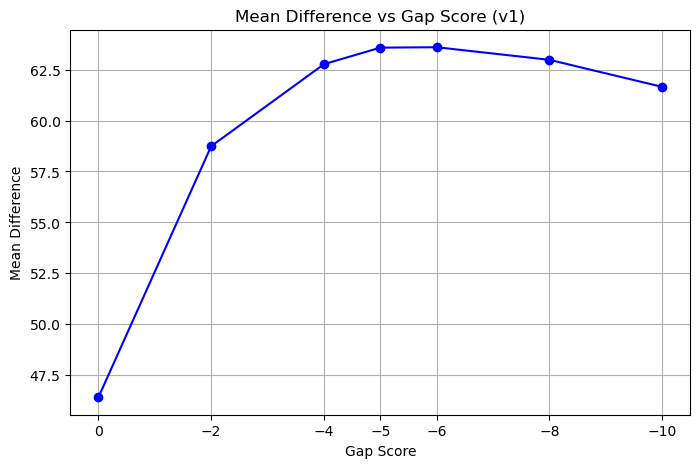

In [310]:
#Generate 2000 positive control and 2000 negative control sequence pairs uisng the generate_pairs_v1 function
positive_control_pairs,negative_control_pairs = generate_pairs_v1(2000)
gap_scores = [ 0, -2, -4, -5, -6, -8, -10 ] #Provided list of gap scores to test for alignment

#Init a dict to store the mean difference between positive and negative scores, with each gap score as keys
diffs = {}

#Loop over each gap score to calculate alignment scores and differences
for gap_score in gap_scores: 
    positive_scores = [] #Init a list to store alignment scores for positive control pairs
    negative_scores = [] #Init a list to store alignment scores for negative control pairs
    
    #Calculate alignment scores for each positive control pair using global_alignment and append to positive_scores list
    for seq1,seq2 in positive_control_pairs:
        positive_scores.append(global_alignment(seq1, seq2, gap_score))

    #Calculate alignment scores for each negative control pair using global_alignment and append to negative_scores list
    for seq1,seq2 in negative_control_pairs:
        negative_scores.append(global_alignment(seq1, seq2, gap_score))

    #Calculate the difference in mean scores between positive and negative control pairs for the current gap score and add it to diff dict
    diffs[gap_score] = (np.mean(positive_scores) - np.mean(negative_scores))
    print(f"Gap score {gap_score}: Mean difference = {diffs[gap_score]:.4f}") #output the gap score and mean difference (4 decimals)

#Convert the gap scores and mean differences into lists for plotting
gap_scores = list(diffs.keys())
mean_differences = list(diffs.values())

#Plotting the results for visualization 
plt.figure(figsize=(8, 5))
plt.plot(gap_scores, mean_differences, marker='o', linestyle='-', color='b')
plt.title("Mean Difference vs Gap Score (v1)")
plt.xlabel("Gap Score")
plt.ylabel("Mean Difference")
plt.grid(True)
plt.xticks(gap_scores) 
plt.gca().invert_xaxis() #Invert the x-axis so the more negative gap scores are on the right, to better visualize the peak 
plt.show()

### Analysis

From the data provided and the graph generated, it is clear that the highest mean difference occurs at a gap score of -6, not -5 as expected. The mean differences for each gap score are:

- Gap score 0: Mean difference = 46.4184
- Gap score -2: Mean difference = 58.7418
- Gap score -4: Mean difference = 62.7659
- Gap score -5: Mean difference = 63.5787
- Gap score -6: Mean difference = 63.5992
- Gap score -8: Mean difference = 62.9811
- Gap score -10: Mean difference = 61.6539

### Interpretation of the Graph:

As expected, the mean difference increases as the gap score becomes more negative (from 0 to -6) and then starts decreasing after -6. This indicates that more negative gap penalties improve discrimination between positive and negative control sequences up to a certain point, but too severe a gap penalty reduces the mean difference after -6. The graph shows a peak at -6, slightly higher than at -5. This is surprising, since the expectation (based on the pset and instructor’s guidance) was that -5 should yield the best result. However, this may be due to several factors such as slight noise in the data or the number of trials, or length biases.

### Possible Reasons for Deviation:

The function `sim_read()` is probabilistic, introducing some variability in the results. The differences between -5 and -6 are quite small (only ~0.02), which might be due to random fluctuations in the simulated data. To reduce this noise, one could increase the number of trials (e.g., from 2000 to 5000 or more) to obtain smoother and more consistent results. Additionally, small inconsistencies such as the input sequence lengths might contribute to the deviation.

I decided to check the mean length of my sim_reads to check if this was the case (since they can be greater than or less than 32 due to insertions or deletions of Ts)


In [312]:
np.mean([len(seq2) for seq1, seq2 in positive_control_pairs])

np.float64(32.794)

### Continuation of analysis

From this we observe that the mean length of the sim_reads is >32 (actual value 32.794). This could potentially be another source of inconsistency. A teaching fellow at office hours recommended setting the length of the sim read to 32 in order to overcome this minute difference between gap_scores.  

When all sequences are the same length, its possible that the alignment scores are more comparable across trials. If some sequences are longer or shorter, the scoring can be affected since the number of gaps or mismatches may increase arbitrarily due to sequence length differences, introducing unnecessary bias. If sequence lengths are not uniformly controlled, the algorithm might over-penalize or under-penalize certain sequences. This variability could make it difficult to identify the optimal gap score accurately, especially since gap penalties play a significant role in aligning sequences of different lengths.

Based on the advice from the teaching assistant, I resolved to try to  ensure that the sequences are all 32 nucleotides long. Inconsistencies in sequence length can directly affect the alignment scores and distort the mean difference between positive and negative controls. Therefore, I will write a **v2** version of the code that ensures all sequences have exactly 32 nucleotides.

In summary, addressing the variability in sequence lengths and increasing the number of trials should lead to more consistent results and likely validate the expected result that -5 is the optimal gap score.


In [313]:
#Essentially the same code as above, key differences noted in comments
def generate_pairs_v2(num_trials):

    positive_control_pairs = [] 
    negative_control_pairs = [] 

    for i in range(num_trials):
        positive_input = generate_random_seq(40) #Generating an input sequence longer than 32. This is to ensure that the 
        #sim_read generated is at least 32 nt long and not less, 40nt was seen to be arbitrarily large enough to achieve this
        positive_sim_pair = sim_read(positive_input)
        positive_control_pairs.append((positive_input[:32],positive_sim_pair[:32])) #limiting the length of the positive control pairs to 32 and only taking the first 32nt

        negative_pair_1 = generate_random_seq(32) 
        negative_pair_2 = generate_random_seq(32) 
        negative_control_pairs.append((negative_pair_1,negative_pair_2))

    return positive_control_pairs,negative_control_pairs

Gap score 0: Mean difference = 39.3731
Gap score -2: Mean difference = 50.9343
Gap score -4: Mean difference = 54.5322
Gap score -5: Mean difference = 55.2019
Gap score -6: Mean difference = 55.1607
Gap score -8: Mean difference = 54.5905
Gap score -10: Mean difference = 53.5772


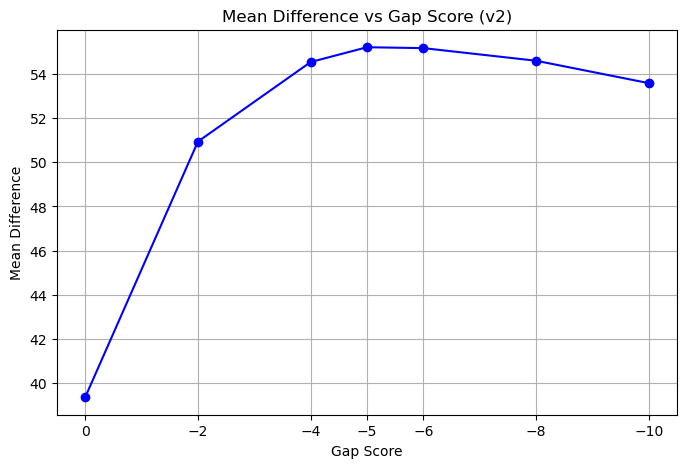

In [323]:
#Redoing the same process as above but now with v2
positive_control_pairs,negative_control_pairs = generate_pairs_v2(2000)
gap_scores = [ 0, -2, -4, -5, -6, -8, -10 ]

diffs = {}

for gap_score in gap_scores: 
    positive_scores = []
    negative_scores = []
    
    for seq1,seq2 in positive_control_pairs:
        positive_scores.append(global_alignment(seq1, seq2, gap_score))
        
    for seq1,seq2 in negative_control_pairs:
        negative_scores.append(global_alignment(seq1, seq2, gap_score))

    diffs[gap_score] = (np.mean(positive_scores) - np.mean(negative_scores))
    print(f"Gap score {gap_score}: Mean difference = {diffs[gap_score]:.4f}")

gap_scores = list(diffs.keys())
mean_differences = list(diffs.values())

plt.figure(figsize=(8, 5))
plt.plot(gap_scores, mean_differences, marker='o', linestyle='-', color='b')
plt.title("Mean Difference vs Gap Score (v2)")
plt.xlabel("Gap Score")
plt.ylabel("Mean Difference")
plt.grid(True)
plt.xticks(gap_scores) 
plt.gca().invert_xaxis()
plt.show()

In [321]:
np.mean([len(seq2) for seq1, seq2 in positive_control_pairs])

np.float64(32.0)

In [322]:
np.mean([len(seq1) for seq1, seq2 in positive_control_pairs])

np.float64(32.0)

After running the v2 version of the alignment experiments, which ensures all sequences are 32 nucleotides in length, I observed that the highest mean difference occurred at a gap score of -5, as expected. The mean differences for each gap score are as follows:

- Gap score 0: Mean difference = 39.3731
- Gap score -2: Mean difference = 50.9343
- Gap score -4: Mean difference = 54.5322
- Gap score -5: Mean difference = 55.2019
- Gap score -6: Mean difference = 55.1607
- Gap score -8: Mean difference = 54.5905
- Gap score -10: Mean difference = 53.5772

### Analysis of Results:

The graph shows an increase in the mean difference as the gap score becomes more negative, with a clear peak at **-5**, aligning with the expectation that -5 should be the optimal gap score. As the gap score becomes more negative beyond -5, the mean difference starts to decrease, showing that overly penalizing gaps reduces the ability to discriminate between positive and negative controls. This is likely because gaps are being penalized too heavily, causing alignments to no longer favor gaps and overall leading to poorer alignment scores.

The trend follows a smooth curve, with -5 yielding the highest mean difference of 55.2019. This suggests that the gap penalty of -5 is optimal for balancing insertions and deletions, as predicted in the problem set guidelines.

### Justification for the Use of -5 as the Optimal Gap Score:

Based on the results from both v1 and v2 versions of my alignment experiment, I conclude that -5 is the most appropriate gap score for the following reasons:

1. **V2 Results**: The v2 version, which ensures all sequences are exactly 32 nucleotides in length, shows a clear peak in the mean difference at -5, with a mean difference of 55.2019. This aligns well with the problem set guidelines, which suggested that -5 should be the optimal gap score. The more controlled nature of v2 eliminates the variability introduced by differing sequence lengths, allowing for a clearer evaluation of the effect of different gap penalties. 

2. **V1 Results and Real-World Considerations**: However, I am not fully convinced by the logic of v2, as it imposes an overly convenient constraint on sequence lengths, which does not reflect the behavior of real-world sequencing systems. In real sequencing systems, especially when dealing with noisy or faulty reads, the read sequence length will naturally vary, and sequences will not always be 32 nucleotides long. In fact, the `sim_read` function simulates these variations by introducing insertions and deletions that affect sequence length. My original code (v1) accurately models this behavior, with variable-length outputs based on real-world expectations.

3. **Small Difference in Scores for -5 vs -6 in V1**: The v1 version of the experiment, which allows for variable sequence lengths, produced only a very small difference in scores between -5 and -6 (63.5787 for -5 and 63.5992 for -6). This suggests that while -6 may appear slightly better in this version, the difference is minimal and could be attributed to random variability in the simulated data. Given this small difference, I believe that -5 remains the optimal choice, especially since it aligns with both the problem set guidelines and the real-world expectations of how gap penalties should behave.

4. **Relying on V1 for Justification**: Although v2 provides a more controlled, convenient result, I will rely on the v1 version for my final justification. V1 is closer to the actual expected behavior of biological systems, where sequencing errors and natural variations result in reads of differing lengths. The results from v1, combined with the small difference between -5 and -6, suggest that -5 is the more realistic and practical gap penalty to use when modeling real-world sequencing data. 

In conclusion, I justify the use of a -5 gap score as it balances both theoretical expectations and the practical considerations of real-world sequencing systems. While v2 provides clarity by controlling for sequence length, v1 reflects the actual variability encountered in noisy systems, making it a more reliable foundation for determining the optimal gap penalty.





# **Task 3**

In [330]:
def glocal_alignment(X, Y, gap_score): 

    #Mapping nucleotide characters to indices for the substitution matrix using a dict
    nt_map = {'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3}

    #First need to init a sigma matrix from which we can draw values for matches or mismatches, values hardcoded from pset instructions
    sigma = np.array([
        [ 1.85, -2.91, -2.91, -2.91 ],  # A row
        [ -2.91, 1.85, -2.91, -2.91 ],  # C row
        [ -2.91, -2.91, 1.85, -2.91 ],  # G row
        [ 0, 0, 0, 0 ]                  # T row
    ])

    #Initialization
    #Need to elongate for correct shape of matrix and also to init top left corner to (0) and for easier matrix indexing 
    #'*' serves as a dummy placeholder to make alignment easier with 1-based indexing
    Y = '*' + Y 
    X = '*' + X 

    L = len(X)
    M = len(Y)

    #Init the scoring matrix F with glocal alignment scores
    F = np.zeros((L,M))
    #Assigning gap penalties for first column of F (only T gaps allowed), penalize with the gap_score; others are set to -inf to heavily penalize and thus not consider non-T gaps due to the nature of Moriarty's model
    #First row left as 0s to allow alignment starting at any position (local nature of glocal)
    for i in range(1,L):
        if X[i] == 'T':
            F[i,0] = i * gap_score #Apply the gap penalty for t gaps
        else:
            F[i,0] = -np.inf #Non-T gaps are heavily penalized (invalid)

    #Recursion 
    #Iterate through pairwise to fill matrix
    for i in range(1,L):
        for j in range(1,M): 
            
            match = F[i-1,j-1] + sigma[nt_map[Y[j]],nt_map[X[i]]] #Get the score for match/mismatch by adding the score, indexing through the way my function deals with actual and read and which axis they are on 

            #Calculate the score for a deletion (gap in X), only allowed if X[i] is T
            if X[i] == 'T': 
                deletion = F[i-1, j] + gap_score #Add gap penalty for T deletion
            else:
                deletion = -np.inf #Non-T deletions are heavily penalized (invalid)

            #Calculate the score for an insertion (gap in Y), only allowed if Y[j] is T
            if Y[j] == 'T':
                insertion = F[i,j-1] + gap_score #Add gap penalty for insertion
            else:
                insertion = -np.inf #Non-T insertions are heavily penalized (invalid)

            F[i,j] = max(match,deletion,insertion)

    #Termination
    #The best alignment score is in the last row of the matrix F
    #Return the best score found in the last row and its position
    return max(F[L-1, :]), np.argmax(F[L-1, :])

            

# **Task 4**

In [333]:
#Copied from Task 4 of Pset01
def parse_fasta(file_name):
   
    dna_sequence = [] #Temporarily storing the sequence as a list of lines from fasta file, to be joined at the end
    
    #Open the FASTA file
    with open(file_name, 'r') as file:
        for line in file:
            line = line.strip()  #Remove any trailing newlines or spaces
            if not line.startswith(">"):  #Ignore header lines using negative conditional and .startswith()
                dna_sequence.append(line)  #Add sequence lines to the list if not header 
    
    #Join the list into a single string to form the complete DNA sequence
    return ''.join(dna_sequence)

In [334]:
read_sequence = parse_fasta('example_read.fa')
genome_citius = parse_fasta('Citius')
genome_tpa4 = parse_fasta('TPA4')
genome_vulture = parse_fasta('Vulture')

In [340]:
print(f"Citius:")
score_citius, position_citius = glocal_alignment(read_sequence, genome_citius, -5)
print(f"   Alignment Score: {score_citius}")
print(f"   Best Match End Position: {position_citius}")

print(f"TPA4:")
score_tpa4, position_tpa4 = glocal_alignment(read_sequence, genome_tpa4, -5)
print(f"   Alignment Score: {score_tpa4}")
print(f"   Best Match End Position: {position_tpa4}")

print(f"Vulture:")
score_vulture, position_vulture = glocal_alignment(read_sequence, genome_vulture, -5)
print(f"   Alignment Score: {score_vulture}")
print(f"   Best Match End Position: {position_vulture}")


Citius:
   Alignment Score: 33.10000000000002
   Best Match End Position: 23902
TPA4:
   Alignment Score: 9.779999999999994
   Best Match End Position: 21714
Vulture:
   Alignment Score: 9.229999999999995
   Best Match End Position: 18048


### Justification for part 4

The alignment results decisively indicate that the genome **Citius** provides the highest alignment score, coming in at **33.1**, in contrast to significantly lower scores of 9.78 for TPA4 and 9.23 for Vulture. This higher score points to a much stronger match between the read sequence and the Citius genome, strongly suggesting that the read sequence is derived from Citius. The large gap in alignment scores across the genomes makes it evident that **Citius is the correct answer**.

Furthermore, the best match occurs at **position 23902** in the Citius genome, reinforcing that the read sequence aligns particularly well with this region, making **Citius the most likely origin of the sequence**.

In [341]:
%load_ext watermark 
%watermark -v -m -p numpy,matplotlib,seaborn,pandas,jupyterlab

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

numpy     : 2.1.1
matplotlib: 3.9.2
seaborn   : 0.13.2
pandas    : 2.2.2
jupyterlab: 4.2.5

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

